# Hello and welcome to interactive PyEarthworm

https://github.com/Boritech-Solutions/PyEarthWorm

https://github.com/Fran89/PyEarthworm_Workshop

This notebook a tutorial that will show you how the PyEarthworm interacts with earthworm.

The first thing we should do is import some basic libraries that will show allow us to work. OS, Sys, Logging and oviously PyEarthworm are the big libraries we should load up. Additionally we will want Numpy.

In [ ]:
import logging, PyEW

### Let's add logging

PyEW uses python's internal logging library which means if we don't modify the logging level we won't see much output from PyEW, unless something went truly wrong. For our purposes let's change this. (We might not see anything in the notebook level, but should if you are using the Python CLI)

In [ ]:
logging.getLogger().addHandler(logging.StreamHandler())

## Assuming Earthworm is currently running let's register a module

This notebook assumes you have an earthworm ring running and looks like this:

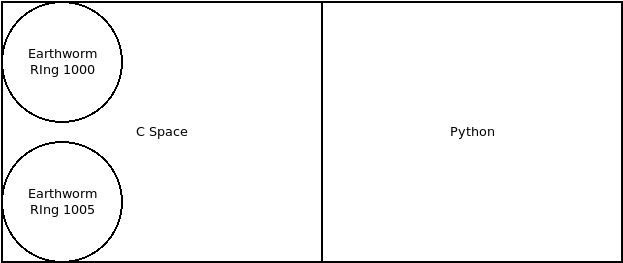

We now have a way to communicate with earthworm via Ring. Let's begin trying to communicate with it. The first thing we should do it is register an Earthworm module with PyEarthworm we do that with the following:

In [ ]:
MyModule = PyEW.EWModule(1000, 8, 141, 30.0, False)

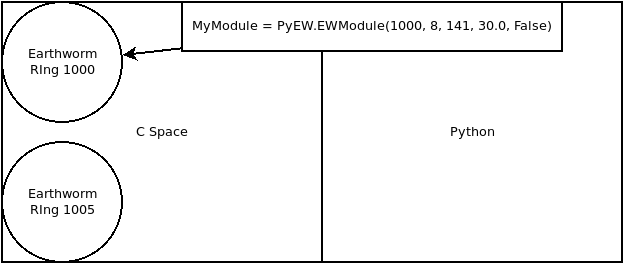

Make sure you only run it once since "threads can only be started once". So what have we done here?  
We defined a module called MyModule:

1. We've set its main ring to (1000) which should be the WAVE_RING. In this ring it will heartbeat and look for stop and restart messages. 
2. It's module ID was set to 8. If we check the earthworm.d should correspond to MOD_PyEWTest
3. The INST_ID was set to 141 which is INST_PRSM. This should be set to the INST_ID we want to send and recieve from.
4. We've set the HeartBeats to 30s
5. We've set the Debug Flag to False

All in all this is how the line goes:

    EWModule(parent ring 1000, mod_id 8, inst_id 141, heartbeat 30s, debug = False)

## Let's add a communication RING

The ring we added at the beginning is the communication ring, but this does nothing. Internal to this module we can add in and out rings with the following

In [ ]:
MyModule.add_ring(1000)

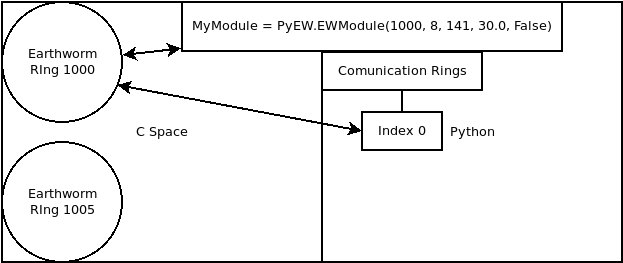


Having added it this ring is now at index 0, any additional rings would be 1, 2, 3, etc...

Let's try aquiring a wave from this ring

In [ ]:
wave = MyModule.get_wave(0)

The relevant method is called __.get_wave(index)__ and it takes the index integer for pulling data.

If this was successfull we now have a wave in the wave variable let's see it

In [ ]:
print(wave)

Alright well there it is. This is what a wave extracted from EW using PyEarthworm looks like. It is a python dictionary that contains the essentials of a tracebuf2 message.

Let's try seeing what it contains:

In [ ]:
print ('Station: ', wave['station'])
print ('Network: ', wave['network'])
print ('Channel: ', wave['channel'])

It's important to note that the data is a numpy array. Now that we have a wave object what do you suppose we can do with it? Well we can try sending it to another ring. The pick ring perhaps?... Let's do that in a terminal I suggest opening up a sniffwave PICK_RING to see if it makes it.

    sniffwave PICK_RING verbose

So to to this let's add the PICK_RING to the module, a quick search of earthworm.d shows us that the pick ring is ID: 1005

In [ ]:
MyModule.add_ring(1005)

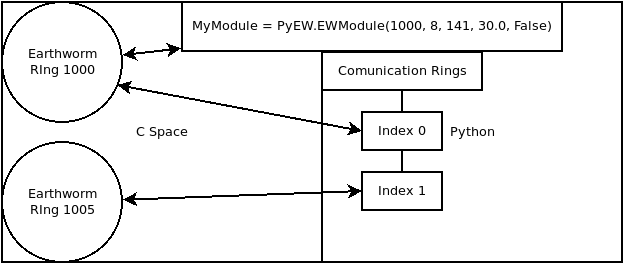

Alright this ring is now our ring at index 1, lets go ahead and try to put this wave there!

In [ ]:
MyModule.put_wave(1, wave)

Did it work? in the output for sniffwave you should have seen something like this:

    AOPR.HNE.PR.-- (0x0 0x0) 0 i4 708 100.0 2019/05/26 01:49:16.06 (1558835356.0600) 2019/05/26 01:49:23.13 (1558835363.1300) i141=INST_PRSM m8=MOD_PyEWTest t19=TYPE_TRACEBUF2 len2896 [D:1380.5s F: 0.0s]

How about we try to add our own wave... Let's define a wave shall we?

In [ ]:
import numpy as np

mywave = {
     'station': 'TEST', 
     'network': 'TT', 
     'channel': 'CH1', 
     'location': '--', 
     'nsamp': 3, 
     'samprate': 1, 
     'startt': 1559760312.00,
     'datatype': 'i4',
     'data': np.array([  1,  -4,  -6], dtype=np.int32)
 }

In [ ]:
MyModule.put_wave(1, mywave)

You should now have something like this

    TTEST.CH1.TT.-- (0x0 0x0) 0 i4   3   1.0 2019/06/05 18:45:12.00 (1559760312.0000) 2019/06/05 18:45:14.00 (1559760314.0000) i141=INST_PRSM m8=MOD_PyEWModule t19=TYPE_TRACEBUF2 len  76 [D:24.14s F:58.6s]

Cool, so what else can we do? Let's try to place a pick message into the pick ring. Now in EW the pick message is essentially a well formatted text string:

    (messageid) (modid) (instid) (index) (STAT).(CHA).(NT).(LC) (Q)(W) (YYYY)(MM)(DD)(HH)(mm)(SS).(ZZZ) (AMP) (??) (??)
    
So let's construct one and place it in the pick ring (RING at idx 1, and Earthworm_Global defines the TYPE_PICK_SCNL as msg_id 8 )

P.S Remember to change the sniffwave to sniffring

    sniffring PICK_RING verbose

In [ ]:
pick  = '8 147 141 20000 TEST.CH1.TT.-- ?1 20190520120516.032 0 0 0'
pick2 = '8 147 141 20001 PN03.HNZ.PR.-- U1 20190605201803.970 112 64 83'

MyModule.put_msg(1,8,pick)
MyModule.put_msg(1,8,pick2)

If everything went well you should see something like this:

    1559767960 Received INST_PRSM MOD_PyEWModule TYPE_PICK_SCNL <seq:  2> <Length:    58>
    8 147 141 20000 TEST.CH1.TT.-- ?1 20190520120516.032 0 0 0
    1559767960 Received INST_PRSM MOD_PyEWModule TYPE_PICK_SCNL <seq:  3> <Length:    62>
    8 147 141 20001 PN03.HNZ.PR.-- U1 20190605201803.970 112 64 83


And there it is we sucessfully added a pick, pretty cool right?

We can add any message as a string:

In [ ]:
MyModule.put_msg(1,104,"Hello from PyEarthworm")

### Checking up on earthworm. 

Let's keep testing this we can ask for a status message:

In [ ]:
MyModule.req_syssta()

It may take a few seconds but this should give us the Earthworm system status!

Here we can try to stop a module...

We simply send the stop message (113) with the Process Id

In [ ]:
proccess_id = str(18675)

MyModule.put_msg(0,113,proccess_id)

# Sleep for 30 seconds and check status again
import time
time.sleep(35)
MyModule.req_syssta()

And now we can try restarting that same process...

We send the restart message (107) with the same Proccess Id

In [ ]:
MyModule.put_msg(0,107,proccess_id)

# Sleep and check again:
time.sleep(5)
MyModule.req_syssta()

### Checking up on this PyEarthworm's status (Maybe it has been stopped or killed!)

We could ask if the module itself is ok, or if earthworm requested a shutdown

In [ ]:
print("Me: Hey MyModule are you ok?")
if (MyModule.mod_sta()):
  print('MyModule: I\'m fine!')
else:
  print('MyModule: I\'m straight up not having a good time')

## Conclution

PyEarthworm offers fast easy communication to the Earthworm internal rings via Python. We will further explore how to make actual modules with parameter files and earthworm style logging.